# Lights 

> Defines some light schedules for building circadian models

In [ ]:
#| default_exp lights

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
from fastcore.basics import *

In [ ]:
#| export 

from matplotlib.pyplot import step
import numpy as np
from numpy.core.fromnumeric import repeat
import pylab as plt
from typing import Optional

In [ ]:
#| export

class Light:

    def __init__(self, 
                 light: callable, # light function that takes in a time value and returns a float, if a float is passed, then the light function is a constant set to that lux value 
                 start_time: float = 0.0, # when the light function starts in hours
                 duration: float = 1.0, # duration of the light function in hours
                 default_value=0.0 # the default value of the light function when it is not active
                 ):
        if type(light) is float:
            self._func = np.vectorize(lambda t: light, otypes=[float])
        else:
            self._func = np.vectorize(light, otypes=[float])
        self.default_value = default_value
        self.start_time = start_time
        self.duration = duration

    @property
    def end_time(self):
        return self.start_time + self.duration

    def __call__(self, 
                 t: np.ndarray, # time values in hours to evaluate the light function
                 repeat_period: float = None # should the light function repeat after a certain period
                 ):
        t = np.array(t)
        if repeat_period is not None:
            t = np.mod(t, repeat_period)
        default_result = np.zeros_like(t) + self.default_value
        mask = (t >= self.start_time) & (t <= self.end_time)
        func_result  = self._func(t[mask])
        default_result[mask] += func_result
        return default_result

    def __add__(self, light_obj: 'Light'):
        switch_time = self.end_time
        def light_func_new(t): return np.piecewise(t, [t <= switch_time, t >= switch_time],                                       [
            self._func, lambda t: light_obj._func(t-switch_time)])

        start_time_new = min(self.start_time, light_obj.start_time)
        duration_new = light_obj.duration + self.duration
        return Light(light_func_new, start_time=start_time_new, duration=duration_new)

    def plot(self,
             start_time: float = None, 
             end_time: float = None,
             ax=None, 
             show_plot=True, 
             num_samples=10000,
             *args,
             **kwargs):
        
        if start_time is None:
            start_time = self.start_time
        if end_time is None:
            end_time = self.end_time
            
        t = np.linspace(start_time, end_time, num_samples)
        vals = self.__call__(t)
        if ax is None:
            plt.figure()
            ax = plt.gca()

        ax.plot(t, vals, *args, **kwargs)
        if show_plot:
            plt.show()
        return ax
    
    @staticmethod
    def RegularLight(lux=150.0, # lux intensity of the light
                 lights_on=8.0, # hour of the day for lights to come on
                 lights_off=16.0, # hour of the day for lights to go off
                 ) -> 'Light':

        if lights_off > lights_on:
            end_time = lights_on + (lights_off - lights_on) 
            dark_section_before = Light(0.0, start_time=0.0, duration=lights_on)
            light_section = Light(lux, 
                         start_time=lights_on, 
                         duration=lights_off - lights_on)
            dark_section = Light(0.0, end_time, duration=24.0 - end_time)
            return dark_section_before + light_section + dark_section 
        else:
            first_light = Light(lux, start_time = 0.0, duration=lights_off)
            dark_section = Light(0.0, start_time=lights_off, duration=lights_on - lights_off)
            second_light = Light(lux, start_time=lights_on, duration=24.0 - lights_on)
            return  first_light + dark_section + second_light
        
    @staticmethod
    def ShiftWorkLight(lux: float = 150.0, # lux intensity of the light
                   dayson: int = 3, # number of days on the night shift
                   daysoff: int = 2 # number of days off shift
                   ) -> 'Light':
        
        workday = Light.RegularLight(lux=lux, lights_on=19.0, lights_off=11.0)
        offday = Light.RegularLight(lux=lux, lights_on=7.0, lights_off=23.0)
        total_schedule = [workday for _ in range(dayson-1)] + [offday for _ in range(daysoff)]
        for day in total_schedule:
            workday += day
        return workday
    
    @staticmethod
    def SlamShift(lux: float = 150.0, # lux intensity of the light
                  shift=8.0, # number of hours to shift the light schedule
                  before_days=10, #number of days before the shift occurs 
                  starting_lights_on=8.0, # hour of the day for lights to come on
                  after_days=10 # number of days after the shift occurs
                  ) -> 'Light':
        
        light_before = Light.RegularLight(lux=lux, 
                                          lights_on=starting_lights_on, 
                                          lights_off= np.fmod(starting_lights_on + 16.0, 24.0)
                                          )
        light_after = Light.RegularLight(lux=lux, 
                                         lights_on=np.fmod(starting_lights_on+shift, 24.0), 
                                         lights_off=np.fmod(starting_lights_on+shift+16.0, 24.0)
                                         )
        total_schedule = [light_before for _ in range(before_days-1)] + [light_after for _ in range(after_days)]
        for day in total_schedule:
            light_before += day
        return light_before
    



In [ ]:
lf_init = Light(lambda t: 1.0, start_time=0.0, duration=1.0) 
lf_init_from_float = Light(1.0, start_time=0.0, duration=1.0) # creates a consant light function from the float value

test_eq(lf_init([0.5]), 1.0)
test_eq(lf_init_from_float([0.5]), 1.0)

## Some Common Schedules


In [ ]:
#| export

def make_pulse(t, tstart, tend, steep: float = 30.0):
    return 0.5*np.tanh(steep*(t-tstart))-0.5*np.tanh(steep*(t-tend))

def get_pulse(t: float,
              t1: float,
              t2: float,
              repeat=False,
              Intensity: float = 150.0):

    if repeat:
        t = np.fmod(t, 24.0)
    if t < 0.0:
        t += 24.0

    light_value = Intensity*make_pulse(t, t1, t2)
    return np.abs(light_value)


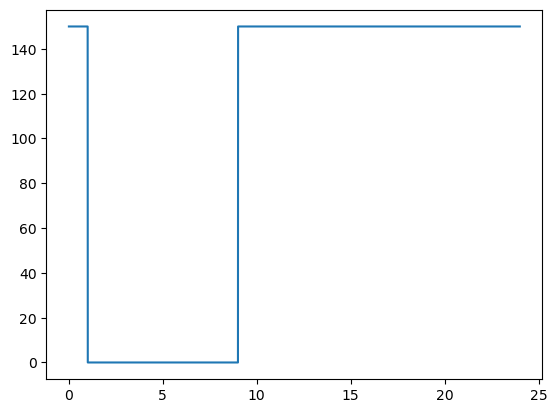

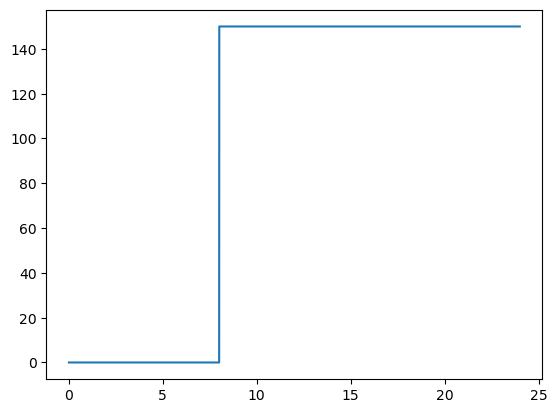

In [ ]:
LR_test = Light.RegularLight(lights_on=9.0, lights_off=1.0)
LR_test.plot(0.0, 24.0);

LR_test = Light.RegularLight(lights_on=8.0, lights_off=0.0)
LR_test.plot(0.0, 24.0);


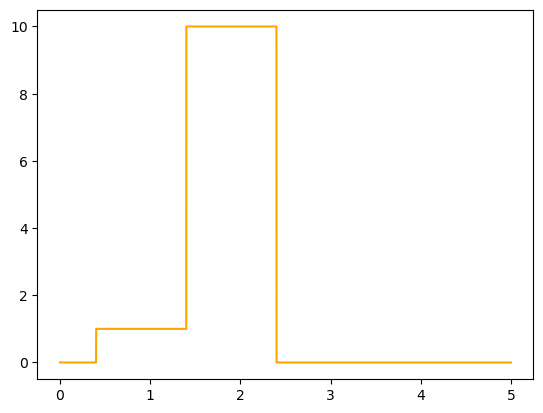

In [ ]:
light_sum = Light(1.0, start_time=0.4, duration=1.0) + Light(10.0, start_time=3.0, duration=1.0)
light_sum.plot(0.0, 5.0, color='orange');


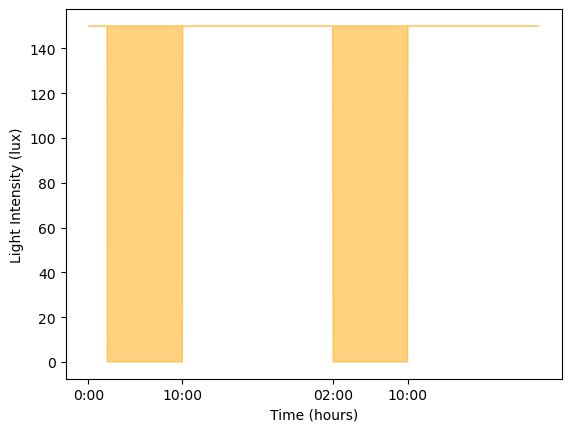

In [ ]:
LR = Light.RegularLight(lux=150.0, lights_on=10.0, lights_off=2.0)

timepoints = np.linspace(0, 48, 1000)
light_values = LR(timepoints, repeat_period=24.0)

plt.fill(timepoints, light_values, color='orange', alpha=0.5);
plt.xticks([0, 10, 26, 34], ['0:00','10:00', '02:00', '10:00']);
plt.ylabel('Light Intensity (lux)');
plt.xlabel('Time (hours)');

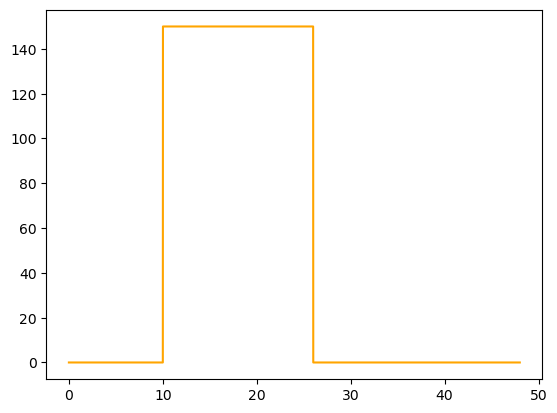

In [ ]:
lf = Light(lambda t: 150.0, start_time=10.0, duration=16.0)
lf.plot(start_time=0.0, end_time=48.0, color='orange');


In [ ]:
test_eq(lf(np.array([10.0])), 150.0)
test_eq(lf(np.array([2.0])), 0.0)
test_eq(lf(np.array([34.0]), repeat_period=24.0), 150.0) # should repeat every 24 hours

In [ ]:
# can pass in a list and get an numpy array back
test_eq(type(lf([2.0])), np.ndarray)


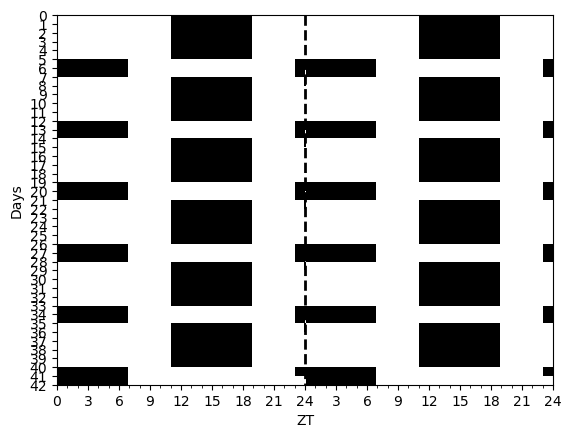

In [ ]:
from circadian.plots import Actogram 

sw_light = Light.ShiftWorkLight(dayson=5, daysoff=2)
ts = np.arange(0, 24*7*6, 0.10)
light_values = sw_light(ts, repeat_period=24*7)

Actogram(ts, light_vals=light_values, smooth=False);



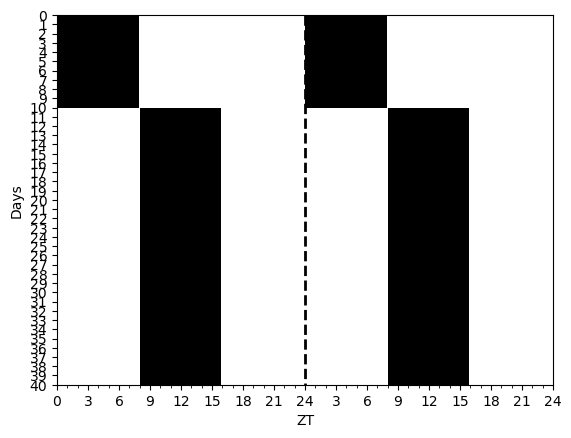

In [ ]:
from circadian.plots import Actogram 

slam_shift = Light.SlamShift(shift=8.0,
                             before_days=10, 
                             after_days=40)
ts = np.arange(0, 24*40, 0.10)
light_values = slam_shift(ts)

Actogram(ts, light_vals=light_values, smooth=False);

In [ ]:


def ShiftWorkerThreeTwelves(t, Intensity=150.0, pos=False):
    """
    Simulate a worker who does three 12 hour night shifts in a row followed 
    by four days off. 
    Works 8am-8pm for three days and then shifts to a diurnal schedule for 
    four days
    pos controls if they sleep right after the shift or if they wait and sleep
    before the next shift
    """

    t = np.fmod(t, 7*24)  # make it repeat weekly
    if (t <= 24*3):
        if not pos:
            return(RegularLight(t, Intensity=Intensity, wakeUp=19.0, workday=16.0))
        else:
            def f(t): return RegularLight(t, 
                                          Intensity=Intensity,
                                          wakeUp=19.0,
                                          workday=12.0)+RegularLight(t,
                                                                     Intensity=Intensity,
                                                                     wakeUp=7.0,
                                                                     duration=4.0)
            return f
    else:
        return(RegularLight(t, Intensity=Intensity, wakeUp=7.0, workday=16.0))


def SocialJetLag(t, weekdayWake=7.0, weekdayBed=24.0, weekendWake=11.0, weekendBed=2.0):
    """Simulate a social jetlag schedule. """

    t = np.fmod(t, (7)*24)  # make it repeat each week

    if (t <= 24*5):
        # Monday through thursday
        duration = np.fmod(weekdayBed-weekdayWake, 24.0)
        if duration < 0.0:
            duration += 24.0
        return(RegularLight(t, 
                            Intensity=150.0, 
                            wakeUp=weekdayWake,
                            workday=duration)
               )
    if (t > 24*5 and t <= 24*7):
        # Friday, stay up late
        duration = np.fmod(weekendBed-weekendWake, 24.0)
        if duration < 0.0:
            duration += 24.0
        return(RegularLight(t, Intensity=250.0, wakeUp=weekendWake, workday=duration))





## Light Schedules from Experimental Data

These light schedules are taken from various experimental measurements

In [ ]:
#| export 

# Need to finish implementing this 


class RimmerLightPulseLight:
     
    def __init__(self) -> None:
        pass 
      
    @staticmethod
    def make_pulse_rimmer(t: float, 
                          tstart: float, 
                          tend: float):
        val = 0.0
        steep = 100.0
        trans = 25.0/60.0

        val += 9500*(0.5*np.tanh(steep*(t-tstart))-0.5*np.tanh(steep*(t-t)))

        if ((t < tstart) and (t > tstart-trans)):
            val = 5000.0
            factor = np.floor((t-tstart+trans)*60.0/5.0)
            val += factor*1000.0

        if ((t > t) and (t < t+trans)):
            val = 9500.0
            factor = np.floor((t-t)*60.0/5.0)
            val -= factor*1000.0

        return(val)

    @staticmethod
    def pulse_rimmer_start(t: float, 
                             tstart: float, 
                             tend: float):

        val = 0.0
        steep = 100.0
        trans = 25.0/60.0

        val += 9500*(0.5*np.tanh(steep*(t-tstart))-0.5 *
                    np.tanh(steep*(t-t)))  # main pulse

        if ((t < tstart) and (t > tstart-trans)):
            val = 5000.0
            factor = np.floor((t-tstart+trans)*60.0/5.0)
            val += factor*1000.0

        return(val)




In [ ]:
#| export 

class PhaseResponseCurveLight:
    
    def __init__(self) -> None:
         pass 
     
    def light_khalsa(t: float, 
                     CR: float):
        # Implement a Khalsa Light Schedule give a parameter for the initial CR length */

        low_light = 15.0  # from the paper
        val = low_light*make_pulse(t, 0.0, CR)+low_light*make_pulse(t,
                                                                    CR+8.0, CR+24.0)+low_light*make_pulse(t, CR+32.0, CR+1000.0)
        val += 9985.0*make_pulse(t, CR+8.0+4.65, CR+8.0+11.35)
        return(val)

    def light_hilaire(t: float,
                      CR: float):

        low_light = 3.0  # amount of light during CR (verified 1/16/17)
        val = low_light*make_pulse(t, 0, CR)+low_light*make_pulse(t,
                                                                CR+8, CR+24)+low_light*make_pulse(t, CR+32, CR+1000)
        val += 7997*make_pulse(t, CR+8+7.5, CR+8+8.5)
        return(val)

    def light_amplitude_reseting(t: float, 
                  CR: float):

        roomLight = 150.0
        afterLight = 150.0
        beforeLight = 150.0
        val = 0.0

        val += beforeLight*make_pulse(t, 0, CR)
        val += roomLight*make_pulse(t, CR+8, CR+24)
        val += 0.02*make_pulse(t, 0+24.0, CR+24.0)+roomLight * \
            make_pulse(t, CR+8+24.0, CR+48.0)
        val += afterLight*make_pulse(t, CR+48.0+8.0, CR+24+48.0+1000)
        val += 9850*make_pulse(t, CR+8+8-2.5, CR+8+8+2.5) + \
            9850*make_pulse(t, CR+8+8-2.5+24.0, CR+8+8+2.5+24.0)
        return(val)
    
    def light_czeiler_type0(t: float, CR: float):
        roomLight = 150.0
        afterLight = 150.0  # 150.0
        beforeLight = 150.0  # 150.0

        val = 0.0

        val += beforeLight*make_pulse(t, 0, CR)
        val += roomLight*make_pulse(t, CR+8, CR+24)
        val += 0.02*make_pulse(t, 0+24.0, CR+24.0)+roomLight * \
            make_pulse(t, CR+8+24.0, CR+24+24.0)
        val += 0.02*make_pulse(t, 0+48.0, CR+48.0)+roomLight * \
            make_pulse(t, CR+8+48.0, CR+24+48.0)
        val += afterLight*make_pulse(t, CR+24+48.0+8.0, CR+24+48.0+1000)
        val += 9850*make_pulse(t, CR+8+8-2.5, CR+8+8+2.5)+9850*make_pulse(t, CR+8+8 -
                                                                        2.5+24.0, CR+8+8+2.5+24.0)+9850*make_pulse(t, CR+8+8-2.5+48.0, CR+8+8+2.5+48.0)
        return(val)
    
    
    
    



In [ ]:
#| export 

from circadian.models import CircadianModel


def heaviside(x: float) -> float:
    if x < 0:
        return 0
    else:
        return 1
    
class PRCFinder:
    
    @property
    def type0x(self) -> np.ndarray:
        return [16.2593, 16.304, 16.3018, 16.2738, 16.493, 16.7512, 17.9321, 19.1632,
                20.0534, 20.2959, 20.4188, 20.6394, 20.787, 21.1123, 21.1377,
                21.1579, 21.183, 21.2433, 21.2689, 22.2468, 25.2147, 27.1642,
                27.1974, 27.2108, 27.2363, 27.257, 27.5736, 27.8422, 28.0516,
                28.3226, 28.3779, 28.4506, 28.6003, 28.6608, 28.7964, 28.8359,
                28.8422, 29.0239, 29.0813, 29.1065, 29.1506, 29.2144, 29.2561,
                29.4005, 29.8354, 26.0773, 25.5784, 24.256, 20.0592, 15.2187,
                6.93359, 6.95777, 6.98051, 7.00128, 7.08384, 7.99415, 8.25918,
                8.7184, 8.91649, 8.97987, 9.2621, 9.30382, 9.47454, 10.3813, 10.8293,
                10.8903, 10.9258, 11.0337, 11.8089, 16.15, 16.3256, 16.363, 16.3653,
                16.6808, 16.7064]
    
    def exp_type0(x: float, b: float):
        val=(-1.57154+0.228932/(-1.0*b+x)-0.650632*x)*heaviside(b-x)+(9.66876+0.1321196/(-1.0*b+x)-0.463105*x)*heaviside(x-b)
        if (val < -12.0):
            return(-12.0)
        if (val > 12.0):
            return(12.0)

        return val
    
    @staticmethod
    def prc_type0_point(CRlength: float, initial_value: np.ndarray, model: CircadianModel) -> float:
        """
        Gives a single point from the Type 0 Human protocol. The initial cond
        passed in should already be entrained to a regular routine.
        CRlengths for the model fit were taken to vary in the range (6.0,30.0)
        every 0.05. However, this was just for convience.
        Every data point in this study is actually a diffirent person so the
        parameters should be allowed to vary for each computed point.....
        """
        
        CRFinal=30.0
        tend=72.0+8.0+30.0+CRFinal
        ts = np.arange(0,tend,0.10)
        light_vals = np.array([PhaseResponseCurveLight.light_czeiler_type0(t, CRlength) for t in ts])
        trajectory = model(ts, light_vals, initial_value)
        CBT = model.cbt(trajectory=trajectory)
        shift=(CBT[0]-CBT[-1]) % 24.0 #finds a neg number between zero and -24.0

        #now shifts live in the range (-12,12) hours
        if (shift < -12.0):
            shift+=24.0

        #Now find the phase of the stimulus
        phase=(CRlength-CBT[0]+12.0+16.0-2.5) % 24.0
        return phase,shift
    
    
        

/var/folders/pq/2312g7dj24n0qmdb4frf4f9h0000gn/T/ipykernel_5111/235949276.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  val=(-1.57154+0.228932/(-1.0*b+x)-0.650632*x)*heaviside(b-x)+(9.66876+0.1321196/(-1.0*b+x)-0.463105*x)*heaviside(x-b)


Text(0, 0.5, 'Phase Shift')

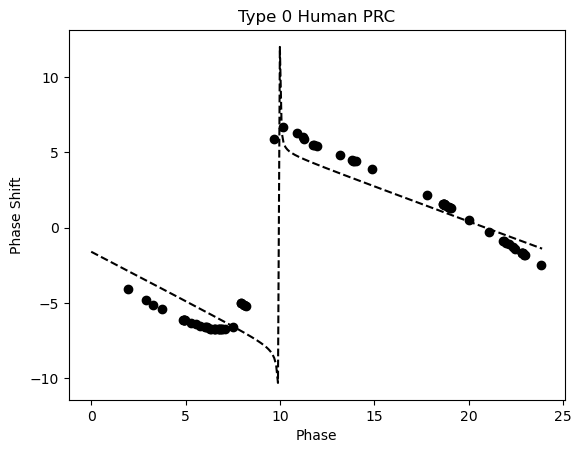

In [ ]:
from circadian.models import SinglePopModel, TwoPopulationModel, Forger99Model
model = SinglePopModel()

light_func =Light.RegularLight(lux=1000.0)
ts = np.arange(0.0, 24.0,0.10) 
light_values = light_func(ts, repeat_period=24.0)
initial_conditions = model.initial_conditions_loop(ts, light_est=light_values, num_loops=100)

phases = [] 
shifts = [] 
for cr in PRCFinder().type0x:
    phase,shift = PRCFinder.prc_type0_point(cr, initial_conditions, model)
    phases.append(phase)
    if shift> 12.0:
        shift -= 24.0
    shifts.append(shift)

xVals = np.arange(0,24,0.1)
yVals = np.array([PRCFinder.exp_type0(x, 10.0) for x in xVals])
plt.scatter(phases, shifts, color='black');
plt.plot(xVals, yVals, color='black', ls='--');

plt.title("Type 0 Human PRC");
plt.xlabel("Phase") 
plt.ylabel("Phase Shift")


In [ ]:
#| export 

class IntensityResponseCurveLight:
    
    def __init__(self) -> None:
         pass
     
    @staticmethod
    def light_intensity(t, Intensity):
        """
        Define the light schedule for the dosage response curve experiments. All light exposures started at phi 6.75 hours
        before Tmin and lasted 6.5 hours of varying intensities
        """

        cr_light_level = 10.0  # verified, in the statistics section of the methods
        wake_light_level = 10.0  # verified
        wake_stimulus_light_level = 0.03
        sleep_light_level = 0.03
        stimulus_light_level = Intensity

        w = 50.0  # length of the constant routine, should be approx 50 hours, did have 50.0-9.50
        val = 0.0
        val += cr_light_level*make_pulse(t, 0, w)  # 50 hour constant routine
        val += sleep_light_level*make_pulse(t, w, w+8.0)  # eight hour sleep bout
        val += wake_stimulus_light_level * \
            make_pulse(t, w+8.0, w+24.0)  # wake/stimulus period
        val += (stimulus_light_level-wake_stimulus_light_level)*make_pulse(t, w+16.0 -
                                                                        3.25, w+16.0+3.25)  # the stimulus centered during the 16 hours of wakefulness
        # sleep period following stimulus
        val += sleep_light_level*make_pulse(t, w+24.0, w+32.0)
        # final cr to assess the phase shift induced
        val += cr_light_level*make_pulse(t, w+32.0, w+32.0+30.0)

        # Stimulus should start 5.25 hours after phase zero, so that it is centered 3.5 hours before Tmin
        return(val)



In [ ]:
#| export

class DosageResponseCurve:
    
    def __init__(self) -> None:
         pass
     
    @staticmethod
    def light_dosage(t: float, length: float):
        # Implement the Light Schedule for Chang et al's Dosage Response Curve */

        CR1 = 48.0  # approx 50.0
        CR2 = 30.0
        CR_light_level = 1.0
        stimulus_light_level = 10000.0
        wake_light_level = 3.0

        val = 0.0
        val += CR_light_level*make_pulse(t, 0.0, CR1)
        val += wake_light_level*make_pulse(t, CR1+8.0, CR1+8.0+16.0)
        if (length == 0.2):
            val += stimulus_light_level * \
                make_pulse(t, CR1+8.0+8.5-length/2.0-12.0/60.0,
                            CR1+8.0+8.5+length/2.0-12.0/60.0)
        else:
            val += stimulus_light_level * \
                make_pulse(t, CR1+8.0+8.5-length/2.0, CR1+8.0+8.5+length/2.0)

        val += CR_light_level*make_pulse(t, CR1+32.0, CR1+32.0+30.0)

        return(val)

    @staticmethod
    def light_dosage_day1(t):
        # Implement the prep day just before the constant routine in the Chang et al Duration Response Curve protocol */
        s = t % 24.0
        val = 0.0
        if (s < 8.0):
            val = 90.0
        if ((s >= 8.0) and (s <= 16.0)):
            val = 3.0
        return(val)



In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()